In [1]:
import pandas as pd

relation = pd.read_csv("FinanceCPT/relationships/random-rels_20_1A.csv", header=None)
relation.columns = ["source", "target", "lag"]
relation = relation[relation["source"] != relation["target"]]

import networkx as nx

G = nx.DiGraph()
for _, row in relation.iterrows():
    G.add_edge(row['source'], row['target'])

In [2]:
from src.scm.ncm.temporal_vae import TemporalVAE
from src.scm.prior.realnvp import FlowPrior

latent_dim = 64
input_dim = 25
seq_length = 5000
batch_size = 300

num_flows = 5 
hidden_dim = 128 

prior = {node: FlowPrior(num_flows=num_flows, 
                                latent_dim=latent_dim, 
                                hidden_dim=hidden_dim) for node in range(input_dim)}

# Initialize model
model = TemporalVAE(
    latent_dim=latent_dim,
    G = G,
    input_dim=input_dim,
    seq_length=seq_length,
    batch_size=batch_size,
    prior=prior
)

In [3]:
import torch as T

ckpt_path = "model_weights/temporal_vae/financial_vae/financial_vae-epoch=999-val_loss=0.20.ckpt"
checkpoint = T.load(ckpt_path, map_location="cpu")
new_state_dict = {}
for key in checkpoint['state_dict'].keys():
    new_key = key.replace("vae.", "")
    new_state_dict[new_key] = checkpoint['state_dict'][key]

# Then replace the old state_dict with the new one
checkpoint['state_dict'] = new_state_dict

model.load_state_dict(checkpoint['state_dict'])


C:\Users\luiso\AppData\Local\Temp\ipykernel_41328\1350445566.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = T.load(ckpt_path, map_location="cpu")


<All keys matched successfully>

In [4]:
import numpy as np

data = pd.read_csv("FinanceCPT/returns/random-rels_20_1A_returns30007000.csv", header=None)

In [5]:
window_size = 20

windows = np.lib.stride_tricks.sliding_window_view(data.values, (window_size, data.shape[1]))

# Reshape to (num_windows, window_size, num_features)
windows = windows.reshape(-1, window_size, data.shape[1])

In [6]:
n_samples = 3981
#z = T.randn(3981,20, 64)
#ran_samp = model.temporal_maps.decode(z).detach().numpy()
ran_samp = model.sample(n_samples, 20).numpy()

In [7]:
import matplotlib.pyplot as plt

plt.hist(windows[:,t_step,dim], bins=500)
plt.hist(ran_samp[:,t_step,dim], bins=500)
plt.show()

NameError: name 't_step' is not defined

In [8]:
do = {"4": {10: 1},
          "7": {5: 1}}
n_samples = 500
n_steps = 11
#do_int = {"X1": {10: .1},
#      "X2": {5: .2}}
ctf_samp = model.ctf_decoder(do, n_samples, n_steps)

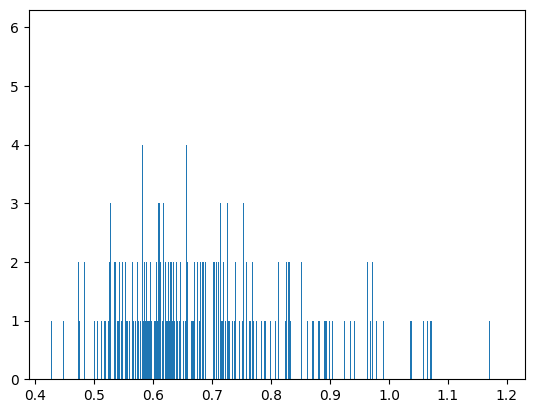

In [9]:
plt.hist(ctf_samp[:,10,4], bins=1000)
plt.show()

### KL Divergence real distribution and our model's distribution

In [10]:
temp = T.from_numpy(windows).float()
mu, log_var = model.encode(temp)
z = model.reparameterize(mu, log_var)
ran_samp = model.temporal_maps.decode(z).detach().numpy()

C:\Users\luiso\AppData\Local\Temp\ipykernel_41328\3265649435.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  temp = T.from_numpy(windows).float()


In [11]:
from scipy.stats import entropy

bins = 10

temp_1 = 0
temp_2 = 0
t_step = 12
#dim = 15

n_samples = 3981
n_steps = 20

matrix = np.zeros((n_steps, 25))

#ctf_samp = model.ctf_decoder(do, n_samples, n_steps)
ran_samp = model.sample(n_samples, n_steps).numpy()

# 25 dimensions in this dataset
for dim in range(25):
    temp_1 = 0
    for idx in range(n_steps):
        #f_val_ori = [i["Y1"].iloc[idx] for i in CDML_dfs]
        #f_val_sam = ran_samp["Y1"][:,idx,0].detach().numpy()

        f_val_ori = windows[:,idx,dim]
        f_val_sam = ran_samp[:,idx,dim]

        p_hist, _ = np.histogram(f_val_ori, bins=bins, density=True)
        q_hist, _ = np.histogram(f_val_sam, bins=bins, density=True)

        # Add a small constant to avoid division by zero and log(0)
        epsilon = 1e-10
        p_hist += epsilon
        q_hist += epsilon

        # Normalize histograms to ensure they sum to 1
        p_hist /= np.sum(p_hist)
        q_hist /= np.sum(q_hist)

        # Compute KL divergence
        kl_div_pq = entropy(p_hist, q_hist)  # D_KL(P || Q)
        kl_div_qp = entropy(q_hist, p_hist)  # D_KL(Q || P)

        #print(kl_div_pq)

        #temp_1 += kl_div_pq

        #matrix[idx, dim] = temp_1
        matrix[idx, dim] = kl_div_pq

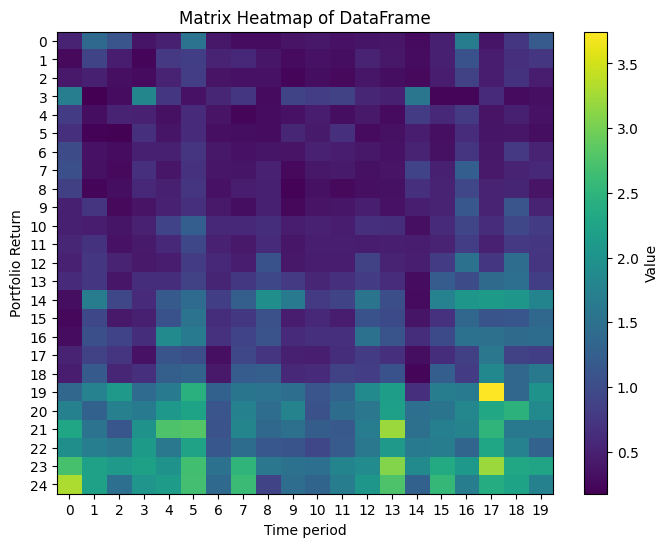

In [12]:
df = pd.DataFrame(matrix)
plt.figure(figsize=(8, 6))
plt.imshow(df.T, aspect='auto', cmap='viridis')  # transpose so columns on y-axis
plt.colorbar(label='Value')
plt.yticks(ticks=np.arange(len(df.columns)), labels=df.columns)
plt.xticks(ticks=np.arange(len(df)), labels=df.index)
plt.xlabel('Time period')
plt.ylabel('Portfolio Return')
plt.title('Matrix Heatmap of DataFrame')
plt.show()

In [216]:
temp_1

0

X is greater or equal to a threshold \
y is greater than a threshold

In [13]:
def theory_bounds(x, y, lag, thres_x, thres_y):

    marg_x = windows[:,:-lag,x]
    marg_y = windows[:,lag:,y]

    p_x = np.mean(marg_x >= thres_x, axis=0)
    p_x_ctf = 1 - p_x
    p_y_and_x_ctf = np.mean((marg_x < thres_x) & (marg_y > thres_y), axis=0)
    p_y_given_x_ctf = p_y_and_x_ctf/p_x_ctf

    p_y_and_x = np.mean((marg_x >= thres_x) & (marg_y > thres_y), axis=0)
    p_y_given_x = p_y_and_x/p_x

    print(p_y_given_x)
    p_l = p_y_given_x_ctf/p_y_given_x

    p_y_ctf_and_x_ctf = np.mean((marg_x < thres_x) & (marg_y < thres_y), axis=0)
    p_y_ctf_given_x_ctf = p_y_ctf_and_x_ctf/p_x_ctf

    p_r = p_y_ctf_given_x_ctf/p_y_given_x
    l_b = np.maximum(0, 1 - p_l)

    #right bound
    r_b = np.minimum(1, p_r)

    return l_b, r_b

In [14]:
thres_x = 1
thres_y = 3
marg_x = windows[:,1:,2]
marg_y = windows[:,:-1,23]
#print(marg_x)

p_y_and_x = np.mean((marg_x >= thres_x) & (marg_y > thres_y), axis=0)
p_x = np.mean(marg_x >= thres_x, axis=0)
g_t_prob = p_y_and_x/p_x

In [15]:
g_t_prob

array([0.01813472, 0.01813472, 0.01813472, 0.01818182, 0.01818182,
       0.01813472, 0.01808786, 0.01813472, 0.01813472, 0.01813472,
       0.01813472, 0.01813472, 0.01813472, 0.01813472, 0.01808786,
       0.01808786, 0.01808786, 0.01808786, 0.01808786])

In [16]:
x = 2
y = 23
thres_x = 1
thres_y = 3

l_b, r_b = theory_bounds(x, y, 1, thres_x, thres_y)

[0.00777202 0.00777202 0.00777202 0.00777202 0.00779221 0.00779221
 0.00777202 0.00775194 0.00777202 0.00777202 0.00777202 0.00777202
 0.00777202 0.00777202 0.00777202 0.00775194 0.00775194 0.00775194
 0.00775194]


In [17]:
l_b

array([0.67788595, 0.67788595, 0.67788595, 0.67788595, 0.67880979,
       0.67880979, 0.67788595, 0.6769616 , 0.67788595, 0.67788595,
       0.67788595, 0.67788595, 0.67788595, 0.67788595, 0.67788595,
       0.6769616 , 0.6769616 , 0.6769616 , 0.6769616 ])

In [18]:
def ctf_prob(inter_idx, thres_x, thres_y, n_steps = 20, n_samples = 1000):    

    # do interventions
    do = {"2": {inter_idx: thres_x}}

    ctf_samp = model.ctf_decoder(do, n_samples, n_steps)

    relation[relation["source"] == do.keys()]

    for i in do.keys():
        temp = relation[relation["source"] == int(i)]
        tar = temp["target"].iloc[0]
        lag = temp["lag"].iloc[0]
        #ctf_sam_paths = var_sam[:, inter_idx+2]

        #print(ctf_samp[:,inter_idx+lag,tar])

        prob = np.mean(ctf_samp[:,inter_idx+lag,tar].numpy() > thres_y,axis=0)


    #ctf_sam_paths = var_sam[:, inter_idx+2]
    #ctf_sam = np.sum((ctf_sam_paths < thres_y))/n_samples
      
    return prob

In [20]:
n_samples = 10000
pr_int = 0
#do_int = {"X1": {10: .1},
#      "X2": {5: .2}}
#ctf_prob_vals = [[ctf_prob(None, i, thres_x, thres_y) for i in range(pr_p_idx, CDML_dfs[0].shape[0]-2)] for _ in range(6)]
co_prob = [[ctf_prob(i,thres_x,thres_y,n_steps,n_samples) for i in range(pr_int, n_steps-1)] for _ in range(6)]

In [21]:
temp = list(zip(*co_prob))
len(co_prob), len(temp)

(6, 19)

In [34]:
thres_x

1

In [57]:
relation

,source,target,lag
0,2,23,1
1,16,8,1
2,11,1,1
3,0,17,1
4,16,5,1
5,1,20,1
6,14,20,1
7,7,2,1
8,1,17,1
9,7,18,1


In [ ]:
real_prob = []


for n_idx in range(0, n_steps-1):
    do = {"2": {n_idx: thres_x}}
    for do_key in do.keys():
        temp = relation[relation["source"] == int(do_key)]
        tar = temp["target"].iloc[0]
        lag = temp["lag"].iloc[0]

        marg_x = windows[:,n_idx,int(do_key)]
        marg_y = windows[:,n_idx+lag,tar]
        #print(marg_x)

        #p_y_and_x = np.mean((marg_x >= thres_x) & (marg_y > thres_y), axis=0)
        #p_x = np.mean(marg_x >= thres_x, axis=0)
        p_y_and_x = np.mean((marg_x >= thres_x) & (marg_y > thres_y), axis=0)
        p_x = np.mean(marg_x >= thres_x, axis=0)

        g_t_prob = p_y_and_x/p_x
        real_prob.append(g_t_prob)

In [58]:
marg_x = windows[:,1:,2]
marg_y = windows[:,:-1,23]
#print(marg_x)

p_y_and_x = np.mean((marg_x >= thres_x) & (marg_y > thres_y), axis=0)
p_x = np.mean(marg_x >= thres_x, axis=0)
g_t_prob = p_y_and_x/p_x

In [61]:
p_x

array([0.09696056, 0.09696056, 0.09696056, 0.09670937, 0.09670937,
       0.09696056, 0.09721176, 0.09696056, 0.09696056, 0.09696056,
       0.09696056, 0.09696056, 0.09696056, 0.09696056, 0.09721176,
       0.09721176, 0.09721176, 0.09721176, 0.09721176])

In [59]:
g_t_prob

array([0.01813472, 0.01813472, 0.01813472, 0.01818182, 0.01818182,
       0.01813472, 0.01808786, 0.01813472, 0.01813472, 0.01813472,
       0.01813472, 0.01813472, 0.01813472, 0.01813472, 0.01808786,
       0.01808786, 0.01808786, 0.01808786, 0.01808786])

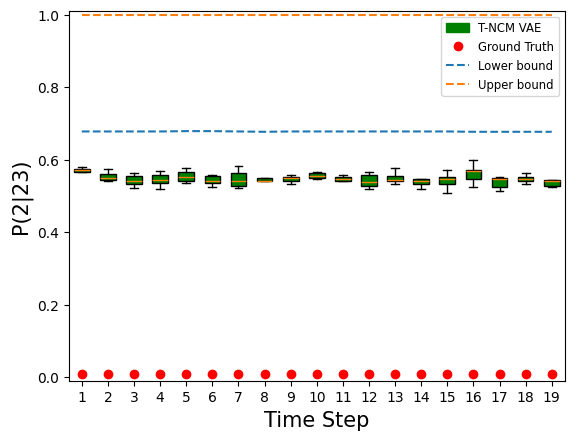

In [67]:
from matplotlib.patches import Patch
temp = list(zip(*co_prob))

fig, ax = plt.subplots()
len_dat = len(temp)
# Plot each box plot separately
positions = np.arange(1, len_dat+1)
capprops = dict(color='blue', linewidth=2)

low_b, = plt.plot(positions,l_b,linestyle="--",label='Lower bound')
up_b, = plt.plot(positions,r_b,linestyle="--",label='Upper bound')

plt.ylim(-.01, 1.01)
for i in range(len_dat):
    bp = ax.boxplot(temp[i], positions=[positions[i]], widths=0.6, showfliers=False, patch_artist=True)

    for box in bp['boxes']:
        box.set_facecolor('green')

ground_truth, = plt.plot(positions,real_prob, marker='o', linestyle='', color='red', label="Ground Truth")
# Customize the plot
ax.set_ylabel('P(2|23)', fontsize=15)
ax.set_xlabel('Time Step', fontsize=15)
# Set the x-axis labels
ax.set_xticks(positions)
boxplot_patch = Patch(color='green', label='T-NCM VAE')
plt.legend(handles=[boxplot_patch, ground_truth, low_b, up_b], labels=['T-NCM VAE', 'Ground Truth', 'Lower bound', 'Upper bound'], loc='upper right', fontsize='small')
plt.show()